# Term Deposit Marketing
## Preprocessing

First, let's import the necessary libraries and load our data.

In [1]:
import numpy as np  
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.stats import chi2_contingency
from sklearn import metrics, tree
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.metrics import f1_score, accuracy_score, classification_report, precision_score,   recall_score 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN, SMOTETomek
from xgboost import XGBClassifier
import warnings
%matplotlib inline

In [2]:
final_data=pd.read_csv('../Data/processed_data.csv')
final_data.head()

,age,default,balance,housing,loan,duration,campaign,y,recency,job_admin,...,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary
0,58.0,0,2143.0,1,0,261.0,1.0,0,241.0,0,...,0,0,0,0,0,1,0,0,0,1
1,44.0,0,29.0,1,0,151.0,1.0,0,241.0,0,...,0,0,1,0,0,0,1,0,1,0
2,33.0,0,2.0,1,1,76.0,1.0,0,241.0,0,...,0,0,0,0,0,1,0,0,1,0
3,47.0,0,1506.0,1,0,92.0,1.0,0,241.0,0,...,0,0,0,0,0,1,0,0,1,0
4,35.0,0,231.0,1,0,139.0,1.0,0,241.0,0,...,0,0,0,0,0,1,0,0,0,1


In [3]:
#Now let's scale our data using StandardScaler
scaler=StandardScaler()

X = final_data.drop(columns='y')
y = final_data['y']
X_scaled=scaler.fit_transform(X)

In [4]:
#Let's first divide our data into training and test subsets
X_train, X_test, y_train, y_test = train_test_split( X_scaled, y, test_size=0.2, random_state=42)

Our next step would be doing some feature selection based on correlation with the target column, F-score, mutual information and Random Forest importance. Let's create custom functions for these tasks. We'll use top 10 features for now.

In [5]:
# We also need Column names map for these functions
columns=X.columns
column_mapping={i:col for i,col in enumerate(columns)}

In [6]:
# Select features
def select_features(X, y, column_mapping, k=10):

    
    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X, columns=[column_mapping[i] for i in range(X.shape[1])])
    
    feature_names = X.columns
    
    # F-score selection
    f_selector = SelectKBest(f_classif, k=k)
    f_selector.fit(X, y)
    
    # selected feature indices
    selected_indices = f_selector.get_support(indices=True)
    selected_feature_names = [feature_names[i] for i in selected_indices]

    
    f_selector_with_names = SelectKBest(f_classif, k=k)
    f_selector_with_names.fit(X, y)  
    
    f_scores = pd.DataFrame({
        'feature': feature_names,
        'f_score': f_selector.scores_,
        'p_value': f_selector.pvalues_
    })
    

    
    return f_scores, f_selector, selected_feature_names

In [7]:
# 3. Main analysis function
def analyze_and_select_features(X_train, X_test, y_train,  column_mapping):
    
   if isinstance(X_train, np.ndarray):
      X_train = pd.DataFrame(X_train, columns=[column_mapping[i] for i in range(X_train.shape[1])])
      X_test = pd.DataFrame(X_test, columns=[column_mapping[i] for i in range(X_test.shape[1])])

   # Select features
   f_scores, f_selector, selected_feature_names = select_features(X_train, y_train, column_mapping)

    
   print("\nTop 10 features by F-score:")
   print(f_scores.sort_values('f_score', ascending=False).head(10))
    
    
    
   # Apply feature selection
   X_train_selected = pd.DataFrame( f_selector.transform(X_train),
        columns=selected_feature_names,
        index=X_train.index)
   
   X_test_selected = pd.DataFrame( f_selector.transform(X_test),
        columns=selected_feature_names,
        index=X_test.index)
   
   X_train_selected = pd.DataFrame(X_train_selected, columns=selected_feature_names)
   X_test_selected = pd.DataFrame(X_test_selected, columns=selected_feature_names)

   feature_importance_df = pd.DataFrame({
        'feature': selected_feature_names,
        'f_score': f_selector.scores_[f_selector.get_support()],
        'p_value': f_selector.pvalues_[f_selector.get_support()]
    })
    
   print("\nSelected features with their importance scores:")
   print(feature_importance_df.sort_values('f_score', ascending=False))
    
   return X_train_selected, X_test_selected, f_selector, selected_feature_names

In [8]:
X_train_selected, X_test_selected, f_selector, selected_feature_names = analyze_and_select_features(X_train, X_test, y_train, column_mapping)

# Print the selected feature names
print("\nSelected features:")
for i, feature in enumerate(selected_feature_names, 1):
    print(f"{i}. {feature}")

# Create a DataFrame with selected features and their importance scores
feature_importance_df = pd.DataFrame({
    'feature': selected_feature_names,
    'f_score': f_selector.scores_[f_selector.get_support()],
    'p_value': f_selector.pvalues_[f_selector.get_support()]
})

print("\nSelected features with their importance scores:")
print(feature_importance_df.sort_values('f_score', ascending=False))


Top 10 features by F-score:
               feature      f_score       p_value
5             duration  8682.668675  0.000000e+00
20     marital_married   117.620525  2.344290e-27
21      marital_single    90.538325  1.937514e-21
3              housing    87.110770  1.090523e-20
6             campaign    69.263064  8.957097e-17
2              balance    69.189776  9.295446e-17
16         job_student    62.064750  3.428810e-15
7              recency    57.915406  2.811897e-14
24  education_tertiary    53.153355  3.156782e-13
9      job_blue-collar    34.019124  5.510042e-09

Selected features with their importance scores:
              feature      f_score       p_value
2            duration  8682.668675  0.000000e+00
7     marital_married   117.620525  2.344290e-27
8      marital_single    90.538325  1.937514e-21
1             housing    87.110770  1.090523e-20
3            campaign    69.263064  8.957097e-17
0             balance    69.189776  9.295446e-17
6         job_student    62.0

In [9]:
X_train_selected.head()

,balance,housing,duration,campaign,recency,job_blue-collar,job_student,marital_married,marital_single,education_tertiary
0,-0.516390,0.810223,-0.321329,-0.714401,0.547098,-0.555729,-0.115557,0.801097,-0.611945,-0.636844
1,-0.626891,0.810223,0.096662,0.106001,-0.010654,-0.555729,-0.115557,-1.248288,1.634133,-0.636844
2,0.224973,-1.234229,1.229281,0.106001,-2.199833,1.799440,-0.115557,0.801097,-0.611945,-0.636844
3,-0.548536,0.810223,-0.820221,-0.714401,0.337941,-0.555729,-0.115557,-1.248288,1.634133,-0.636844
4,-0.515385,-1.234229,0.141607,-0.714401,-0.317418,-0.555729,-0.115557,0.801097,-0.611945,1.570242


Before we start our modeling process, let's take a look at the distribution of the values for our target column value distribution.

In [10]:
y.value_counts()

y
0    36886
1     2879
Name: count, dtype: int64

Our majority class is almost 13 times bigger than the minority class. This would affect our models performance, therefore let's address that first.

Let's try NearMiss-3 undersampling method for our highly imabalanced dataset, which selects k nearest majority samples for each minority sample

In [11]:
nm3 = NearMiss(version=3, n_neighbors=3)
X_train_balanced, y_train_balanced = nm3.fit_resample(X_train_selected, y_train)

In [12]:
y_train_balanced.value_counts()

y
0    2284
1    2284
Name: count, dtype: int64

## Modeling

Now we'll try 3 ML algorithms for our data: Logistic Regression, Random Forest and XGBoost

In [13]:
# 1. Logistic Regression
lr = LogisticRegression(random_state=42, max_iter=5000)
lr.fit(X_train_balanced, y_train_balanced)
lr_pred = lr.predict(X_test_selected)
lr_train_score = lr.score(X_train_balanced, y_train_balanced)
lr_test_score = lr.score(X_test_selected, y_test)
lr_f1 = f1_score(y_test, lr_pred)

print("Logistic Regression Results:")
print(f"Training Accuracy: {lr_train_score:.3f}")
print(f"Test Accuracy: {lr_test_score:.3f}")
print(f"F1 Score: {lr_f1:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, lr_pred))

# 2. Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_balanced, y_train_balanced)
rf_pred = rf.predict(X_test_selected)
rf_train_score = rf.score(X_train_balanced, y_train_balanced)
rf_test_score = rf.score(X_test_selected, y_test)
rf_f1 = f1_score(y_test, rf_pred)

print("\nRandom Forest Results:")
print(f"Training Accuracy: {rf_train_score:.3f}")
print(f"Test Accuracy: {rf_test_score:.3f}")
print(f"F1 Score: {rf_f1:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, rf_pred))

# 3. XGBoost
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train_balanced, y_train_balanced)
xgb_pred = xgb.predict(X_test_selected)
xgb_train_score = xgb.score(X_train_balanced, y_train_balanced)
xgb_test_score = xgb.score(X_test_selected, y_test)
xgb_f1 = f1_score(y_test, xgb_pred)

print("\nXGBoost Results:")
print(f"Training Accuracy: {xgb_train_score:.3f}")
print(f"Test Accuracy: {xgb_test_score:.3f}")
print(f"F1 Score: {xgb_f1:.3f}")
print("\nClassification Report:")
print(classification_report(y_test, xgb_pred))

Logistic Regression Results:
Training Accuracy: 0.628
Test Accuracy: 0.845
F1 Score: 0.384

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.86      0.91      7358
           1       0.27      0.65      0.38       595

    accuracy                           0.84      7953
   macro avg       0.62      0.75      0.65      7953
weighted avg       0.92      0.84      0.87      7953


Random Forest Results:
Training Accuracy: 1.000
Test Accuracy: 0.719
F1 Score: 0.277

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.72      0.83      7358
           1       0.17      0.72      0.28       595

    accuracy                           0.72      7953
   macro avg       0.57      0.72      0.55      7953
weighted avg       0.91      0.72      0.78      7953


XGBoost Results:
Training Accuracy: 0.951
Test Accuracy: 0.793
F1 Score: 0.339

Classification Report:
              pre

It seems like all 3 models are having hard time capturing our minority class examples, which is resulting very low precision results. Let's try to do some parameter tuning to find the limit of these algorithms on our data, after which we'll try to address our data imbalance using other techniques.

In [14]:
# Parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}


grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(X_train_balanced, y_train_balanced)

# Random Forest results
print("\nRandom Forest Results:")
print("Best Parameters:")
print(grid_rf.best_params_)
print(f"\nBest Cross-validation F1 Score: {grid_rf.best_score_:.3f}")

# Evaluate best Random Forest on test set
best_rf = grid_rf.best_estimator_
best_rf_pred = best_rf.predict(X_test_selected)
print("\nRandom Forest Test Set Results:")
print(classification_report(y_test, best_rf_pred))

Fitting 5 folds for each of 162 candidates, totalling 810 fits

Random Forest Results:
Best Parameters:
{'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}

Best Cross-validation F1 Score: 0.669

Random Forest Test Set Results:
              precision    recall  f1-score   support

           0       0.97      0.73      0.83      7358
           1       0.18      0.74      0.29       595

    accuracy                           0.73      7953
   macro avg       0.58      0.73      0.56      7953
weighted avg       0.91      0.73      0.79      7953



In [16]:
# parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [50, 200, 500],
    'max_depth': [2, 6, 12],
    'learning_rate': [0.001, 0.01, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 5, 10],
    'gamma': [0, 0.2, 0.5]
}


grid_xgb = GridSearchCV(
    XGBClassifier(random_state=42),
    param_grid_xgb,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

print("Training XGBoost...")
grid_xgb.fit(X_train_balanced, y_train_balanced)

# Print XGBoost results
print("\nXGBoost Results:")
print("Best Parameters:")
print(grid_xgb.best_params_)
print(f"\nBest Cross-validation F1 Score: {grid_xgb.best_score_:.3f}")

# Evaluate best XGBoost on test set
best_xgb = grid_xgb.best_estimator_
best_xgb_pred = best_xgb.predict(X_test_selected)
print("\nXGBoost Test Set Results:")
print(classification_report(y_test, best_xgb_pred))

Training XGBoost...
Fitting 5 folds for each of 2187 candidates, totalling 10935 fits

XGBoost Results:
Best Parameters:
{'colsample_bytree': 0.8, 'gamma': 0.5, 'learning_rate': 0.001, 'max_depth': 12, 'min_child_weight': 10, 'n_estimators': 200, 'subsample': 0.6}

Best Cross-validation F1 Score: 0.698

XGBoost Test Set Results:
              precision    recall  f1-score   support

           0       0.98      0.75      0.85      7358
           1       0.20      0.77      0.32       595

    accuracy                           0.75      7953
   macro avg       0.59      0.76      0.58      7953
weighted avg       0.92      0.75      0.81      7953



It seems that even with tuned hyperparameters, NearMiss 3 was not able to deliver acceptable results. Let's try oversampling techniques this time since the small size of the data might be the main reason of low metrics on minority class.

In [17]:
sampling_techniques = {
    'SMOTE': SMOTE(random_state=42),
    'ADASYN': ADASYN(random_state=42),
    'SMOTEENN': SMOTEENN(random_state=42),
    'SMOTETomek': SMOTETomek(random_state=42)
}

# Try each sampling technique with XGBoost
results = {}
for name, sampler in sampling_techniques.items():
    print(f"\nTrying {name}...")
    

    X_resampled, y_resampled = sampler.fit_resample(X_train_selected, y_train)
    
    # Train XGBoost with best parameters
    xgb = XGBClassifier(**grid_xgb.best_params_, random_state=42)
    xgb.fit(X_resampled, y_resampled)
    
    # Make predictions
    y_pred = xgb.predict(X_test_selected)
    
    # Calculate metrics
    results[name] = {
        'F1 Score': f1_score(y_test, y_pred),
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred)
    }
    
    print(f"{name} Results:")
    print(classification_report(y_test, y_pred))

# Compare results
results_df = pd.DataFrame(results).T
print("\nComparison of Sampling Techniques:")
print(results_df)


Trying SMOTE...
SMOTE Results:
              precision    recall  f1-score   support

           0       0.99      0.91      0.94      7358
           1       0.42      0.85      0.56       595

    accuracy                           0.90      7953
   macro avg       0.70      0.88      0.75      7953
weighted avg       0.94      0.90      0.92      7953


Trying ADASYN...
ADASYN Results:
              precision    recall  f1-score   support

           0       0.99      0.89      0.94      7358
           1       0.39      0.86      0.54       595

    accuracy                           0.89      7953
   macro avg       0.69      0.88      0.74      7953
weighted avg       0.94      0.89      0.91      7953


Trying SMOTEENN...
SMOTEENN Results:
              precision    recall  f1-score   support

           0       0.99      0.84      0.91      7358
           1       0.32      0.92      0.48       595

    accuracy                           0.85      7953
   macro avg       0.66 

It seems that SMOTETomek performed the best, let's try to build a new model based on this sampling technique. </br>

We'll use the following technique: </br> Create a ranked list of our features, using the function from earlier and then starting from 1 feature add features one by one to see how they affect the F1 score.

In [24]:
f_scores, f_selector, selected_feature_names = select_features(X, y, column_mapping, k=26)

feature_addition_results = []

# Adding features one by one
for i in range(1, len(selected_feature_names) + 1):
    current_features = selected_feature_names[:i]

    print(f"Trying with {i} features: {current_features}")

    feature_indices = [list(selected_feature_names).index(feature) for feature in current_features]

    X_train_current = X_train[:, feature_indices]
    X_test_current = X_test[:, feature_indices]
    
    
    # Using NearMiss-3 again to handle imbalance
    ST = SMOTETomek(random_state=42)
    X_st, y_st = ST.fit_resample(X_train_current, y_train)

    
    # Train XGBoost
    xgb = XGBClassifier(**grid_xgb.best_params_, random_state=42)
    xgb.fit(X_st, y_st)
    
    # Make predictions
    y_pred = xgb.predict(X_test_current)
    
    # Calculate metrics
    current_results = {
        'n_features': i,
        'features': current_features,
        'F1 Score': f1_score(y_test, y_pred),
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred)
    }
    
    feature_addition_results.append(current_results)
    
    print(f"\nResults with {i} features:")
    print(classification_report(y_test, y_pred))

# Convert results to DataFrame
results_df = pd.DataFrame(feature_addition_results)

c:\Users\sirak\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:783: UserWarning: k=26 is greater than n_features=25. All the features will be returned.
  warnings.warn(
c:\Users\sirak\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:783: UserWarning: k=26 is greater than n_features=25. All the features will be returned.
  warnings.warn(


Trying with 1 features: ['age']

Results with 1 features:
              precision    recall  f1-score   support

           0       0.93      0.73      0.82      7358
           1       0.10      0.35      0.15       595

    accuracy                           0.70      7953
   macro avg       0.51      0.54      0.49      7953
weighted avg       0.87      0.70      0.77      7953

Trying with 2 features: ['age', 'default']

Results with 2 features:
              precision    recall  f1-score   support

           0       0.93      0.66      0.77      7358
           1       0.09      0.43      0.15       595

    accuracy                           0.64      7953
   macro avg       0.51      0.54      0.46      7953
weighted avg       0.87      0.64      0.73      7953

Trying with 3 features: ['age', 'default', 'balance']

Results with 3 features:
              precision    recall  f1-score   support

           0       0.94      0.70      0.80      7358
           1       0.10      0


Best Feature Combination:
Number of features: 17
F1 Score: 0.582

Features:
- age
- default
- balance
- housing
- loan
- duration
- campaign
- recency
- job_admin
- job_blue-collar
- job_entrepreneur
- job_housemaid
- job_management
- job_retired
- job_self-employed
- job_services
- job_student

Detailed Results:
 n_features  F1 Score  Accuracy  Precision   Recall
          1  0.151025  0.703131   0.096066 0.352941
          2  0.150730  0.641519   0.091600 0.425210
          3  0.166777  0.683390   0.103832 0.423529
          4  0.164761  0.687665   0.102984 0.411765
          5  0.164428  0.679241   0.102116 0.421849
          6  0.469388  0.869232   0.336996 0.773109
          7  0.485730  0.879920   0.357369 0.757983
          8  0.569052  0.902301   0.424669 0.862185
          9  0.559648  0.899283   0.415850 0.855462
         10  0.568683  0.904061   0.428450 0.845378
         11  0.580240  0.907582   0.439446 0.853782
         12  0.572887  0.905319   0.432363 0.848739
        

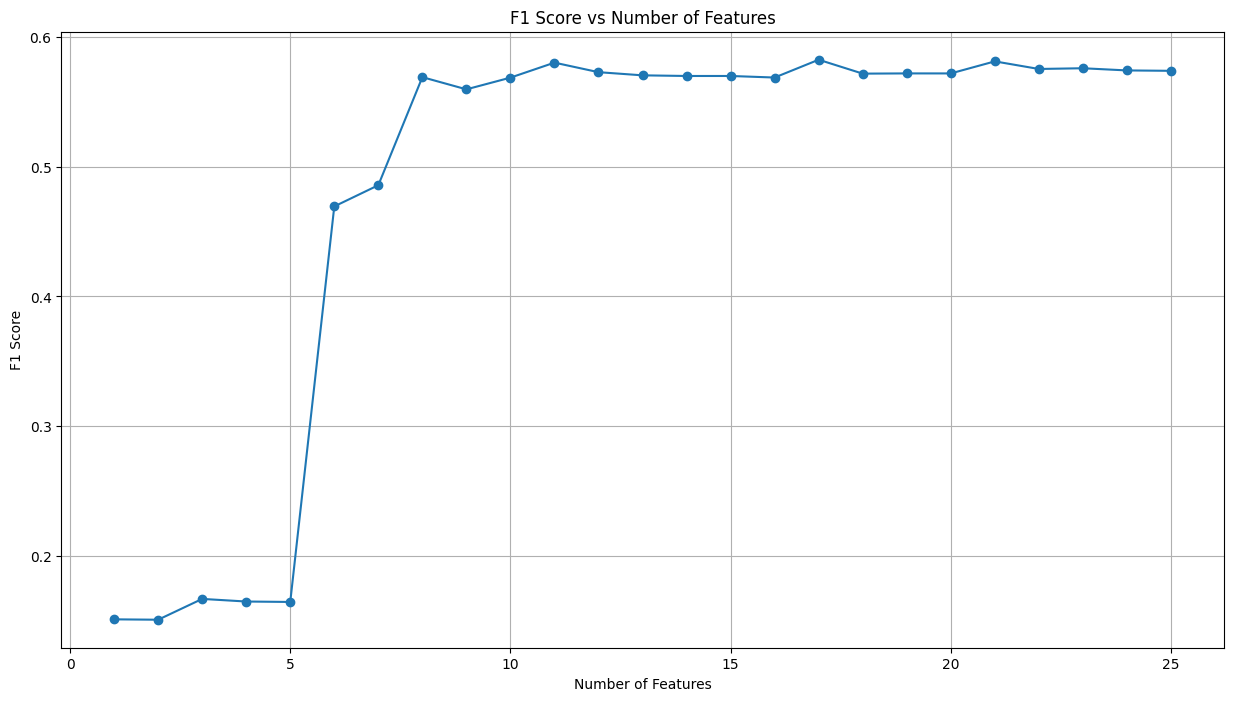

In [26]:
# Plot F1 score vs number of features
plt.figure(figsize=(15, 8))
plt.plot(results_df['n_features'], results_df['F1 Score'], marker='o')
plt.title('F1 Score vs Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('F1 Score')
plt.grid(True)



# Print best feature combination
best_result = results_df.loc[results_df['F1 Score'].nlargest().index[0]]
print("\nBest Feature Combination:")
print(f"Number of features: {best_result['n_features']}")
print(f"F1 Score: {best_result['F1 Score']:.3f}")
print("\nFeatures:")
for feature in best_result['features']:
    print(f"- {feature}")

# Print detailed results table
print("\nDetailed Results:")
print(results_df[['n_features', 'F1 Score', 'Accuracy', 'Precision', 'Recall']].to_string(index=False))

# Save the best feature combination
best_features = best_result['features']

It looks like 17 features show the best f1 score on our XGBoost model. Now let's combine all of our findings and train our 17 feature data on the following models: Logistic Regression, Decision Trees, Random Forest, XGBoost, KNN and SVM.

In [32]:
X_train_df = pd.DataFrame(X_train, columns=selected_feature_names)
X_test_df = pd.DataFrame(X_test, columns=selected_feature_names)

X_train_current = X_train_df[best_features]
X_test_current = X_test_df[best_features]

ST = SMOTETomek(random_state=42)
X_train_m, y_train_m = ST.fit_resample(X_train_current, y_train)

In [33]:
# Logistic Regression
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'class_weight': ['balanced', None] 
}

grid_lr = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid_lr,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

print("Training Logistic Regression...")
grid_lr.fit(X_train_m, y_train_m)

# Print Logistic Regression results
print("\nLogistic Regression Results:")
print("Best Parameters:")
print(grid_lr.best_params_)
print(f"\nBest Cross-validation F1 Score: {grid_lr.best_score_:.3f}")

# Evaluate best Logistic Regression on test set
best_lr = grid_lr.best_estimator_
best_lr_pred = best_lr.predict(X_test_current)

print("\nLogistic Regression Test Set Results:")
print(classification_report(y_test, best_lr_pred, zero_division=0))

Training Logistic Regression...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Logistic Regression Results:
Best Parameters:
{'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}

Best Cross-validation F1 Score: 0.828

Logistic Regression Test Set Results:
              precision    recall  f1-score   support

           0       0.98      0.84      0.91      7358
           1       0.29      0.80      0.43       595

    accuracy                           0.84      7953
   macro avg       0.64      0.82      0.67      7953
weighted avg       0.93      0.84      0.87      7953



In [34]:
# Decision Tree
param_grid_dt = {
    'max_depth': [3, 5, 7, 9, 11, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],
    'class_weight': ['balanced', None]  
}

grid_dt = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid_dt,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

print("Training Decision Tree...")
grid_dt.fit(X_train_m, y_train_m)

# Print Decision Tree results
print("\nDecision Tree Results:")
print("Best Parameters:")
print(grid_dt.best_params_)
print(f"\nBest Cross-validation F1 Score: {grid_dt.best_score_:.3f}")

# Evaluate best Decision Tree on test set
best_dt = grid_dt.best_estimator_
best_dt_pred = best_dt.predict(X_test_current)

print("\nDecision Tree Test Set Results:")
print(classification_report(y_test, best_dt_pred, zero_division=0))

Training Decision Tree...
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Decision Tree Results:
Best Parameters:
{'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}

Best Cross-validation F1 Score: 0.933

Decision Tree Test Set Results:
              precision    recall  f1-score   support

           0       0.96      0.93      0.95      7358
           1       0.39      0.57      0.46       595

    accuracy                           0.90      7953
   macro avg       0.68      0.75      0.70      7953
weighted avg       0.92      0.90      0.91      7953



In [36]:
# Random Forest
param_grid_rf = {
    'n_estimators': [100, 300],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
}

grid_rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid_rf,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

print("Training Random Forest...")
grid_rf.fit(X_train_m, y_train_m)

# Print Random Forest results
print("\nRandom Forest Results:")
print("Best Parameters:")
print(grid_rf.best_params_)
print(f"\nBest Cross-validation F1 Score: {grid_rf.best_score_:.3f}")

# Evaluate best Random Forest on test set
best_rf = grid_rf.best_estimator_
best_rf_pred = best_rf.predict(X_test_current)


print("\nRandom Forest Test Set Results:")
print(classification_report(y_test, best_rf_pred, zero_division=0))

Training Random Forest...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Random Forest Results:
Best Parameters:
{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 300}

Best Cross-validation F1 Score: 0.957

Random Forest Test Set Results:
              precision    recall  f1-score   support

           0       0.97      0.94      0.96      7358
           1       0.48      0.68      0.56       595

    accuracy                           0.92      7953
   macro avg       0.72      0.81      0.76      7953
weighted avg       0.94      0.92      0.93      7953



In [37]:
# KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_knn = GridSearchCV(
    KNeighborsClassifier(),
    param_grid_knn,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

print("Training KNN...")
grid_knn.fit(X_train_m, y_train_m)

# Print KNN results
print("\nKNN Results:")
print("Best Parameters:")
print(grid_knn.best_params_)
print(f"\nBest Cross-validation F1 Score: {grid_knn.best_score_:.3f}")

# Evaluate best KNN on test set
best_knn = grid_knn.best_estimator_
best_knn_pred = best_knn.predict(X_test_current)


print("\nKNN Test Set Results:")
print(classification_report(y_test, best_knn_pred, zero_division=0))

Training KNN...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

KNN Results:
Best Parameters:
{'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}

Best Cross-validation F1 Score: 0.948

KNN Test Set Results:
              precision    recall  f1-score   support

           0       0.97      0.90      0.93      7358
           1       0.35      0.63      0.45       595

    accuracy                           0.88      7953
   macro avg       0.66      0.77      0.69      7953
weighted avg       0.92      0.88      0.90      7953



In [ ]:
# SVM
param_grid_svm = {
    'C': [0.1, 1, 10, 100], 
    'kernel': ['linear', 'rbf'], 
    'gamma': ['scale', 0.1, 0.01]
}

grid_svm = GridSearchCV(
    SVC(random_state=42, probability=True),
    param_grid_svm,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

print("Training SVM...")
grid_svm.fit(X_train_m, y_train_m)

# Print SVM results
print("\nSVM Results:")
print("Best Parameters:")
print(grid_svm.best_params_)
print(f"\nBest Cross-validation F1 Score: {grid_svm.best_score_:.3f}")

# Evaluate best SVM on test set
best_svm = grid_svm.best_estimator_
best_svm_pred = best_svm.predict(X_test_current)


print("\nSVM Test Set Results:")
print(classification_report(y_test, best_svm_pred, zero_division=0))

Training SVM...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [38]:
# XGBoost
param_grid_xgb = {
    'n_estimators': [100, 300],
    'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

grid_xgb = GridSearchCV(
    XGBClassifier(random_state=42),
    param_grid_xgb,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

print("Training XGBoost...")
grid_xgb.fit(X_train_m, y_train_m)

# Print XGBoost results
print("\nXGBoost Results:")
print("Best Parameters:")
print(grid_xgb.best_params_)
print(f"\nBest Cross-validation F1 Score: {grid_xgb.best_score_:.3f}")

# Evaluate best XGBoost on test set
best_xgb = grid_xgb.best_estimator_
best_xgb_pred = best_xgb.predict(X_test_current)


print("\nXGBoost Test Set Results:")
print(classification_report(y_test, best_xgb_pred, zero_division=0))

Training XGBoost...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

XGBoost Results:
Best Parameters:
{'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 300, 'subsample': 0.8}

Best Cross-validation F1 Score: 0.956

XGBoost Test Set Results:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      7358
           1       0.51      0.57      0.54       595

    accuracy                           0.93      7953
   macro avg       0.74      0.77      0.75      7953
weighted avg       0.93      0.93      0.93      7953



It looks like that all of our algorithms showed acceptable F1 score results on the test data, but XGBoost performed the best, showing F1 score  of 0.96. Now let's take a look at the features, affecting the model performance the most.

In [ ]:
feature_importances = best_xgb.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': best_features, 
    'Importance': feature_importances
})

feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance_df.head(10))